# Example 1 : Time series SRA

Time series analysis to compute surface response spectrum and site 
amplification functions.

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

import pysra

%matplotlib inline
# Larger figures
mpl.rcParams['figure.dpi'] = 150

## Load time series data

In [2]:
fname = 'data/NIS090.AT2'
with open(fname) as fp:
    next(fp)
    description = next(fp).strip()
    next(fp)
    parts = next(fp).split()
    time_step = float(parts[1])

    accels = [float(p) for l in fp for p in l.split()]

    ts = pysra.motion.TimeSeriesMotion(
        fname, description, time_step, accels)

In [3]:
ts.accels

array([  2.33833000e-07,   2.99033000e-07,   5.15835000e-07, ...,
         4.90601000e-05,   4.94028000e-05,   4.96963000e-05])

There are a few supported file formats. AT2 files can be loaded as follows:

In [4]:
ts = pysra.motion.TimeSeriesMotion.load_at2_file(fname)
ts.accels

array([  2.33833000e-07,   2.99033000e-07,   5.15835000e-07, ...,
         4.90601000e-05,   4.94028000e-05,   4.96963000e-05])

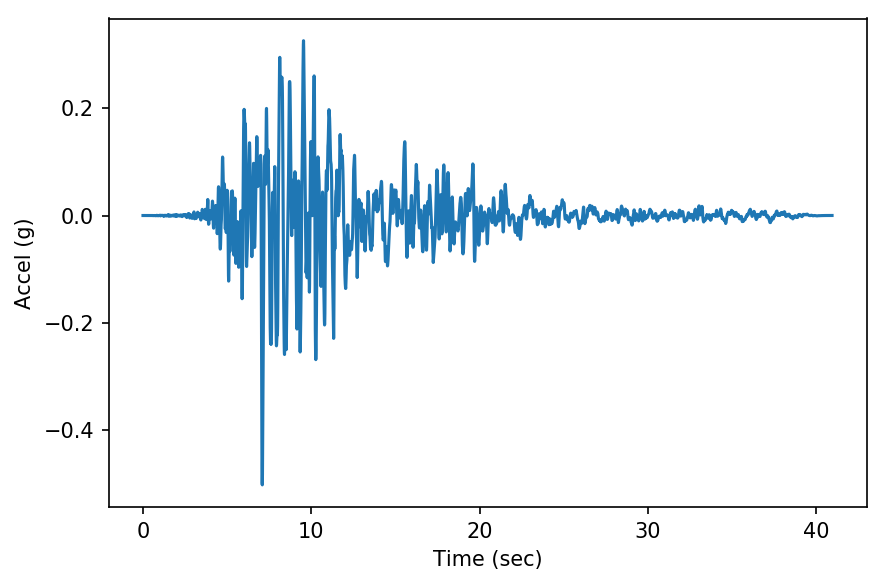

In [5]:
fig, ax = plt.subplots()
ax.plot(ts.times, ts.accels)
ax.set(xlabel='Time (sec)', ylabel='Accel (g)')
fig.tight_layout();

## Create site profile

This is about the simplest profile that we can create. Linear-elastic soil and rock.

In [6]:
profile = pysra.site.Profile([
    pysra.site.Layer(
        pysra.site.SoilType(
            'Soil', 18., None, 0.05
        ),
        30, 400
    ),
    pysra.site.Layer(
        pysra.site.SoilType(
            'Rock', 24., None, 0.01
        ),
        0, 1200
    ),
])

## Create the site response calculator

In [7]:
calc = pysra.propagation.LinearElasticCalculator()

## Specify the output

In [8]:
freqs = np.logspace(-1, 2, num=500)

outputs = pysra.output.OutputCollection(
    pysra.output.ResponseSpectrumOutput(
        # Frequency
        freqs, 
        # Location of the output
        pysra.output.OutputLocation('outcrop', index=0), 
        # Damping
        0.05
    ),
    pysra.output.ResponseSpectrumRatioOutput(
        # Frequency
        freqs, 
        # Location in (denominator),
        pysra.output.OutputLocation('outcrop', index=-1), 
        # Location out (numerator)
        pysra.output.OutputLocation('outcrop', index=0), 
        # Damping
        0.05
    ),
    
)

## Perform the calculation

Compute the response of the site, and store the state within the calculation object. Nothing is provided.

In [9]:
calc(ts, profile, profile.location('outcrop', index=-1))

Calculate all of the outputs from the calculation object.

In [10]:
outputs(calc)

## Plot the outputs

Create a few plots of the output.

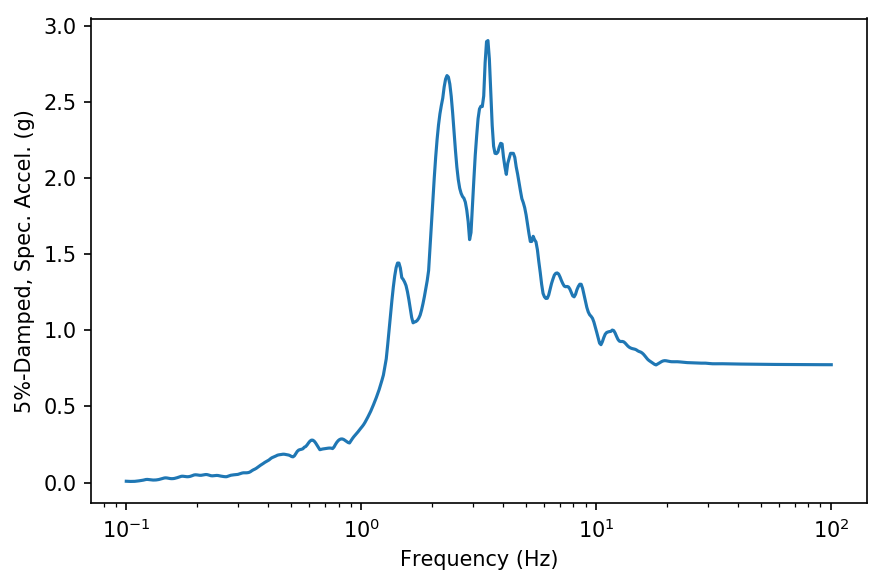

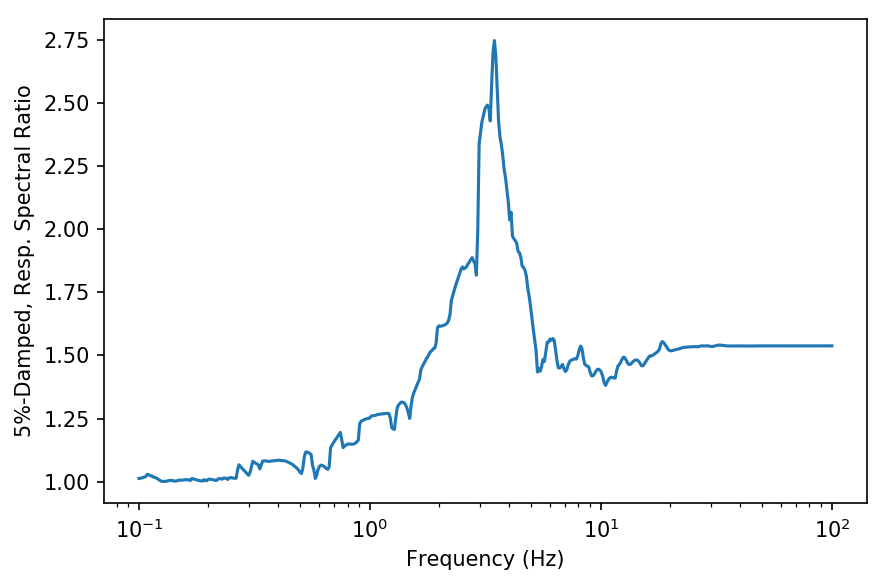

In [11]:
for o in outputs:
    fig, ax = plt.subplots()
    ax.plot(o.refs, o.values)
    ax.set(xlabel=o.xlabel, xscale='log', ylabel=o.ylabel)
    fig.tight_layout();